# The Heart of the Matter: Analyzing Predictors of Heart Disease



## Introduction

Heart disease is the number 1 cause of deaths worldwide, with no 'cure' of any kind. We can, however, try to identify possible factors that lead to higher risk of heart disease. We obtained a set of data collected by Robert Detrano, (M.D., Ph.D.) from the Long Beach and Cleveland Clinic Foundation. This data set contains a total of 76 attributes, of which 14 are used as primary data. We will be using this data to craft a model that attempts to predict whether or not age, sex, total cholestoral levels, maximum heart rate and number of major vessels affected by flourosopy affect the diagnosis of heart disease. 

## Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [51]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(url, destfile = "data/processed.cleveland.data")
heart_df <- read_csv("data/processed.cleveland.data", col_name = FALSE)
col <- c("age", "sex","cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal","num")
colnames(heart_df) <- col
head(heart_df)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


We wiil extract the columns that we need and prepare them for analysis

In [83]:
filheart_df <- select(heart_df, -cp, -trestbps, -fbs, -restecg, -exang, -oldpeak, -slope, -thal)
head(filheart_df)

heart_num0 <- filheart_df |>
filter(num == 0)
heart_num1 <- filheart_df |>
filter(num > 0) |>
mutate(num = 1)

heart_clean <- rbind(heart_num0, heart_num1)
heart_clean <- heart_clean |>
mutate(num = as_factor(num), ca = as.integer(ca), sex = as_factor(sex))
head(heart_clean)

age,sex,chol,thalach,ca,num
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
63,1,233,150,0.0,0
67,1,286,108,3.0,2
67,1,229,129,2.0,1
37,1,250,187,0.0,0
41,0,204,172,0.0,0
56,1,236,178,0.0,0


Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,chol,thalach,ca,num
<dbl>,<fct>,<dbl>,<dbl>,<int>,<fct>
63,1,233,150,0,0
37,1,250,187,0,0
41,0,204,172,0,0
56,1,236,178,0,0
57,0,354,163,0,0
57,1,192,148,0,0


In [87]:
# Here we use prop = 0.7 but we may change as we build our model
split <- initial_split(heart_clean, prop = 0.7, strata = num)
heart_train <- training(split)
heart_test <- testing(split)
# head(heart_train)
# head(heart_test)

### Summary of predictor variables
We report counts for categorical variables and means for quantitative variables as well as number of NA values for each variable.

In [89]:
num_counts <- heart_train |>
group_by(num) |>
summarize(count = n())
ca_counts <- heart_train |>
group_by(ca) |>
summarize(count = n())
means_by_num  <- heart_train %>%
        group_by(num) %>%
        summarize(avg_age = mean(age), avg_chol = mean(chol), avg_thal = mean(thalach))
print("Counts of num")
num_counts
print("Counts of ca")
ca_counts
print("Means of quantitative variables given num")
means_by_num

[1] "Counts of num"


num,count
<fct>,<int>
0,114
1,97


[1] "Counts of ca"


ca,count
<int>,<int>
0,123
1,52
2,21
3,12
NA,3


[1] "Means of quantitative variables given num"


num,avg_age,avg_chol,avg_thal
<fct>,<dbl>,<dbl>,<dbl>
0,52.95614,240.0877,158.5614
1,56.30928,252.0515,138.9794


### Visualization
We visualize distribution of each column. Some rough trends can be observed just by colouring based on the presense of heart disease.

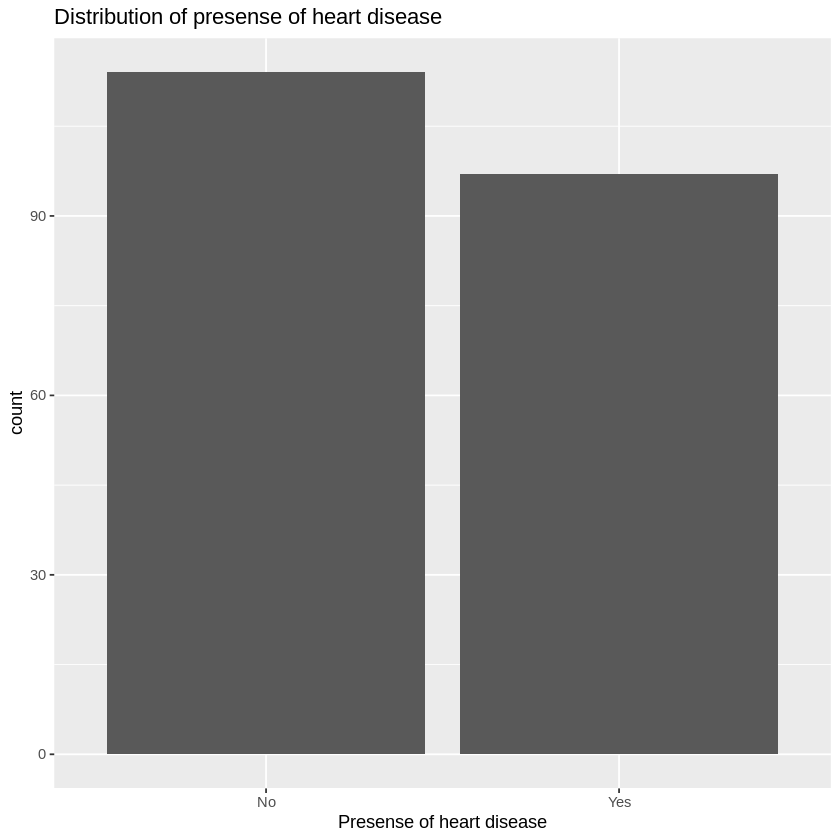

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



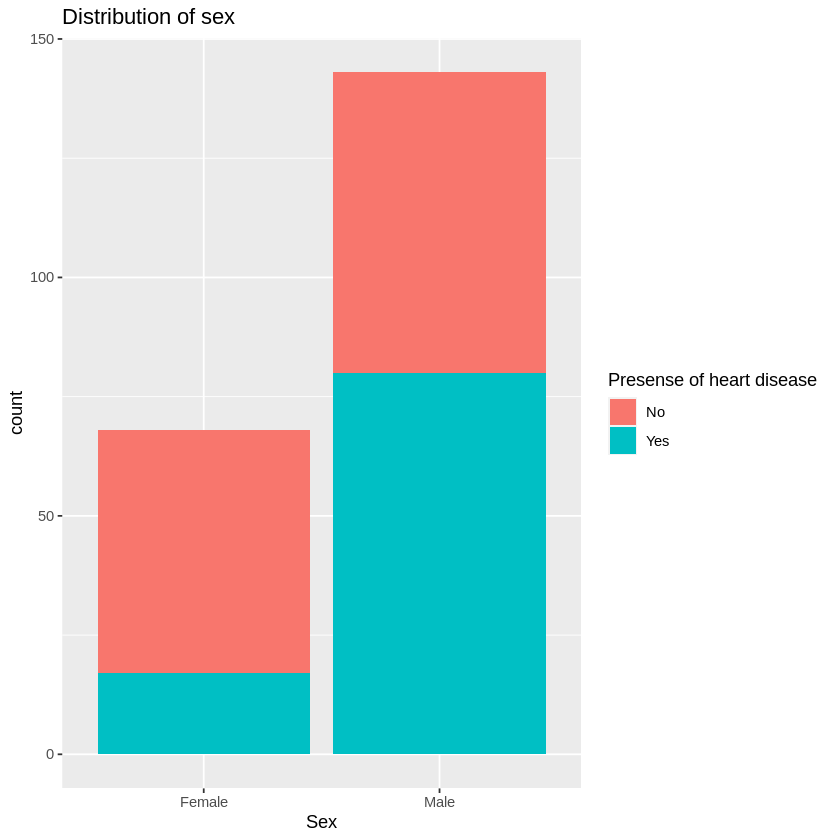

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



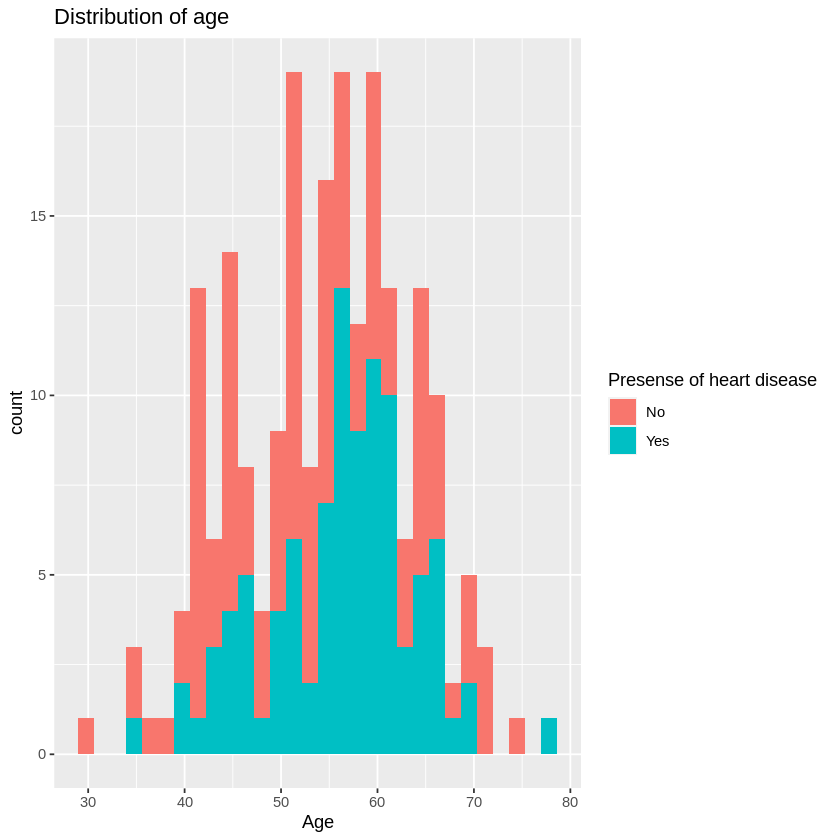

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



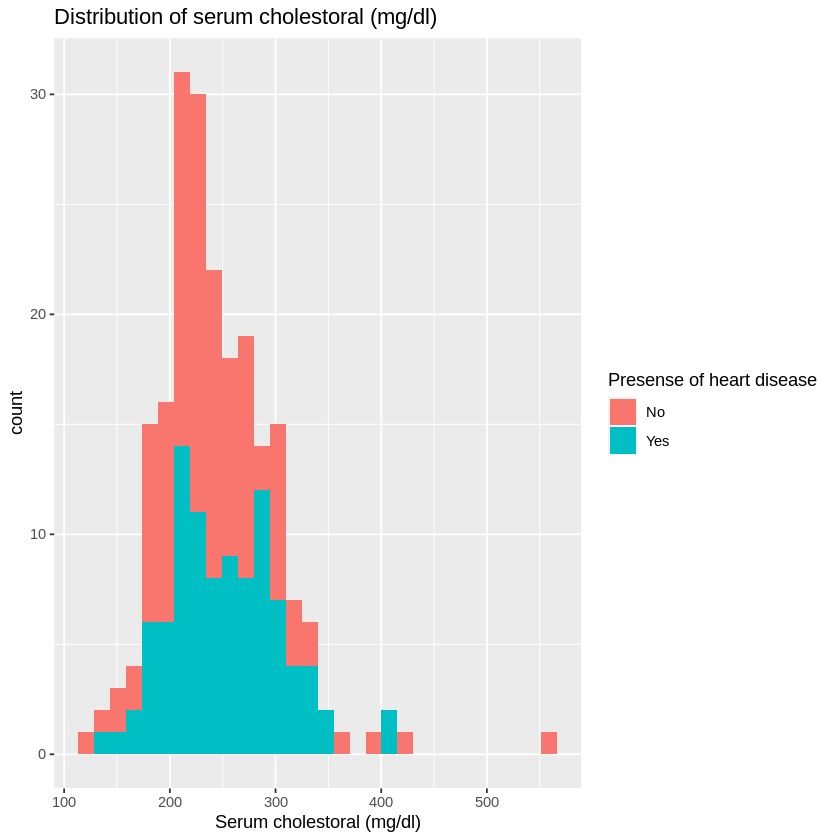

Warning message:
“Removed 3 rows containing non-finite values (stat_count).”


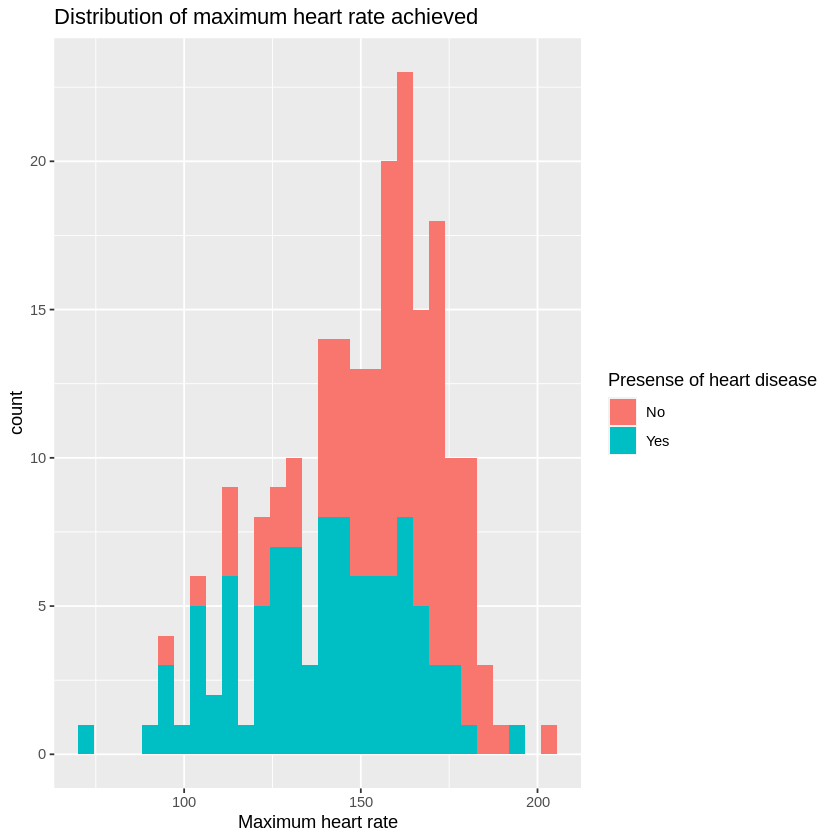

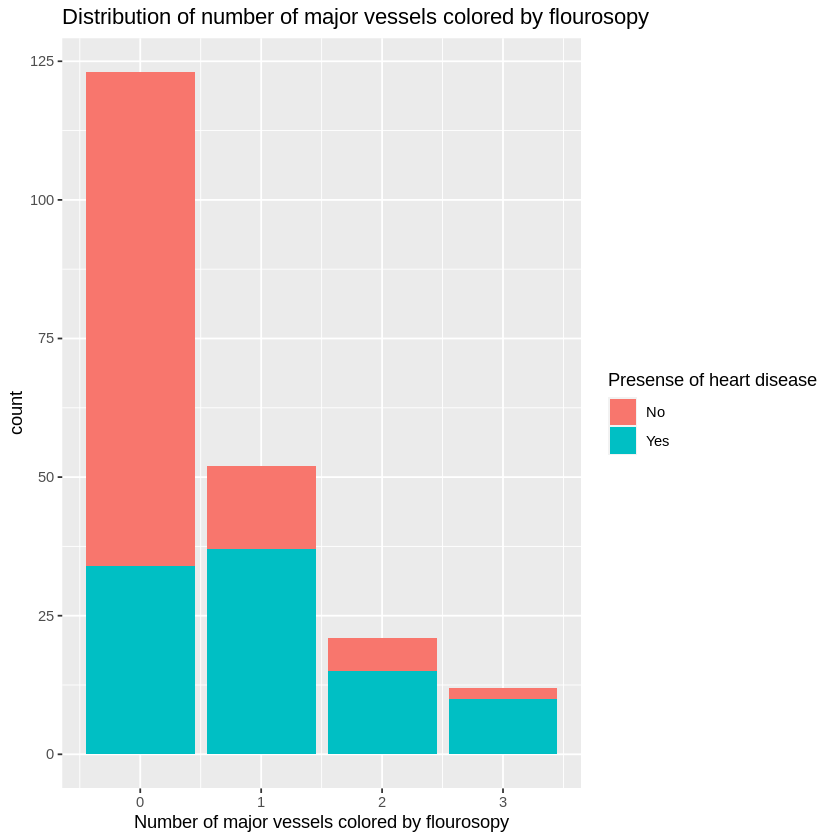

In [90]:
num_plot <- ggplot(heart_train, aes(x = num)) +
geom_bar() +
labs(x = "Presense of heart disease", title = "Distribution of presense of heart disease")+
scale_x_discrete(labels = c('No','Yes'))
num_plot

sex_plot <- ggplot(heart_train, aes(x= sex, fill = num)) +
geom_bar(position = "stack") + 
labs(x = "Sex", title = "Distribution of sex", fill = "Presense of heart disease") +
scale_fill_hue(labels = c("No", "Yes"))+
scale_x_discrete(labels = c('Female','Male'))
sex_plot

age_plot <- ggplot(heart_train, aes(x= age, fill = num)) +
geom_histogram(position = "stack") +
labs(x = "Age", title = "Distribution of age", fill = "Presense of heart disease") +
scale_fill_hue(labels = c("No", "Yes"))
age_plot

chol_plot <- ggplot(heart_train, aes(x= chol, fill = num)) +
geom_histogram(position = "stack") +
labs(x = "Serum cholestoral (mg/dl)", title = "Distribution of serum cholestoral (mg/dl)", fill = "Presense of heart disease") +
scale_fill_hue(labels = c("No", "Yes"))
chol_plot

thalach_plot <- ggplot(heart_train, aes(x= thalach, fill = num)) +
geom_histogram(position = "stack") +
labs(x = "Maximum heart rate", title = "Distribution of maximum heart rate achieved", fill = "Presense of heart disease") +
scale_fill_hue(labels = c("No", "Yes"))
thalach_plot

ca_plot <- ggplot(heart_train, aes(x= ca, fill = num)) +
geom_bar(position = "stack")+
labs(x = "Number of major vessels colored by flourosopy", title = "Distribution of number of major vessels colored by flourosopy", fill = "Presense of heart disease") +
scale_fill_hue(labels = c("No", "Yes"))
ca_plot



## Methods

We will use knn to predict the instance of heart disease with our chosen factors. We will be using are age (age), sex (sex), cholesterol level(in mg/dl) (chol), maximum heart rate achieved (thalach), number of major vessels colored by flourosopy (ca), and the diagnosis of heart disease (num). For clarity, sex is a binary variable that is coded as male = 1 and femake = 0. Number of major vessels is measured from 0-3 and converted to integer. The diagnosis is initially measured from 0-4: 0 indicating no presence and 1-4 indicating presence of heart disease. We mutated this into a binary variable so that 0 indicates no diagnosis and 1 indicates diagnosis. 

To visualize our results, we will be using scatterplots between two variables that were found to have a significant influence in prection with the color function to indicate the instance of heart disease or not. This will help to explain the combinatory power of the two variables in the prediction of heart disease. 


## Expected outcomes and significance

We expect to find that these variables (age, cholesterol level, maximum heart rate achieved, number of major vessels colored by flourosopy, and sex) affect the likelihood of heart disease in patients. Therefore, we expect to see predictive value. 
                                
Findings such as this could have an impact on how doctors communicate health risks to patients. It may also affect how patients change their daily life as certain risks may have increased predictive value of a variable, such as cholesterol level. 

This could lead to future questions about the compounding effect of these variables and all other variables that serve predictive purposes. Knowing how these chosen variables affect the instance of heart disease, questions about other predictive variables such as blood pressure, smoking, or obesity can also be tested individually and together. Interactions between these variables could be a very important question. 
